# Track Momentum Reconstruction
In this tutorial, we introduce track momentum (energy) reconstruction with CSDA range-based energy tables and ADC pixel depositions. 

In [1]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re

import seaborn as sns
sns.set(rc={
    'figure.figsize':(20, 10), 
})
sns.set_context('talk') # or paper

# Visualization Tools
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
pwd

'/sdf/home/k/koh0207/workshop/icarus_ml_workshop_2023/reconstruction/track_calorimetry'

In [3]:
# Set paths
LARTPC_MLRECO_PATH = "/sdf/group/neutrino/koh0207/lartpc_mlreco3d/"
sys.path.append(LARTPC_MLRECO_PATH)

In [4]:
# Load anatools config file
anaconfig = './track_momentum.cfg'
anaconfig = yaml.safe_load(open(anaconfig, 'r'))

In [5]:
# Initialize Anatools manager
from analysis.manager import AnaToolsManager
manager = AnaToolsManager(anaconfig, cfg=None)
manager.initialize()

Welcome to JupyROOT 6.22/08
Registered /sdf/data/neutrino/icarus/workshop2023/reco/bnb_numu_corsika_mini_reco.h5


In [6]:
# Forward a single image-worth of data (when running the full chain)
# data, result = manager.forward()

# Get entry number #ENTRY_NUM from HDF5 (when reading from HDF5)
ENTRY_NUM = 0
data, result = manager.forward(iteration=ENTRY_NUM)

In [7]:
# manager.build_representations(data, result, mode='all')
manager.load_representations(data, result, mode='all')

In [8]:
# Retrieving data structures
particles          = result['particles'][0]
truth_particles    = result['truth_particles'][0]
interactions       = result['interactions'][0]
truth_interactions = result['truth_interactions'][0]

## 1. Introduction

For muon energy reconstruction, two methods are in general use: *range-based (CSDA) energy reconstruction* and *multiple-coulomb scattering (MCS)*. In this tutorial, we will mostly consider *range-based energy reconstruction*. 

### 1-1. Range-based Energy Reconstruction

Recll that the stopping power $S(E)$ of a particle usually refers to the energy loss rate 𝑑𝐸/𝑑𝑥 when it passes through matter. When charged particles (such as a muon) travel through our LArTPC detector, they interact with the argon and lose energy:

$$ S(E) = - \frac{dE}{dx}.$$

The mean range, or the *continuous slowing down approximation (CSDA)* range $\Delta x$ can be computed as:

$$\Delta x = \int_0^{E_0} \frac{1}{S(E)} \ dE,$$

where $E_0$ is the initial kinetic energy of the muon. In practice, this integral is computed for a range of $E_0$ values and saved as a [table](https://pdg.lbl.gov/2012/AtomicNuclearProperties/MUON_ELOSS_TABLES/muonloss_289.pdf). The energy of the muon could then be reconstructed from the range (length) of the muon by reading off the $E_0$ value corresponding to the measured $\Delta x$ from the table (in practice, we will fit a cubic spline to the table). However, the muon should be fully contained inside the fidicial volume and the range fo the muon should be well-reconstructed. Note that the *range* is defined as the total arc length between the muon's true start point and stopping point. 

In summary, for range-based energy reconstruction, we need the following methods:
 * A function to compute the track's range, given its 3D voxel coordinates.
 * A interpolating function for the muon CSDA range table. 

In [9]:
def compute_track_length(points: np.ndarray, **kwargs):
    """Compute track length by dividing it into segments and computing 
    a local PCA axis, then summing the local lengths of the segments.

    Parameters
    ----------
    points: np.ndarray
        Shape (N, 3)
    bin_size: int, optional
        Size (in voxels) of the segments

    Returns
    -------
    length: float
        The reconstructed length (range) of the track. 
    """
    pass
    # Implement your solution here

In [10]:
# One such solution is provided here
from analysis.post_processing.reconstruction.calorimetry import compute_track_length
# Different solution using splines
from analysis.post_processing.reconstruction.calorimetry import compute_track_length_splines

In [11]:
# Get tracks
reco_tracks = [p for p in particles if p.semantic_type == 1]
true_tracks = [p for p in truth_particles if p.semantic_type == 1]

In [12]:
# Sanity check, 
diffs, lengths = [], []
lengths2 = []
for p in true_tracks:
    diffs.append(np.linalg.norm(p.start_point - p.end_point))
    lengths.append(compute_track_length(p.truth_points))
    lengths2.append(compute_track_length_splines(p.truth_points))

For sanity check, let's plot the difference between the end point and start point vs. the reconstructed range for truth particles:

> **Warning**:
> Note that `p.end_point - p.start_point` will not give you the truth range of the track (in particular, if the muon is curved). 

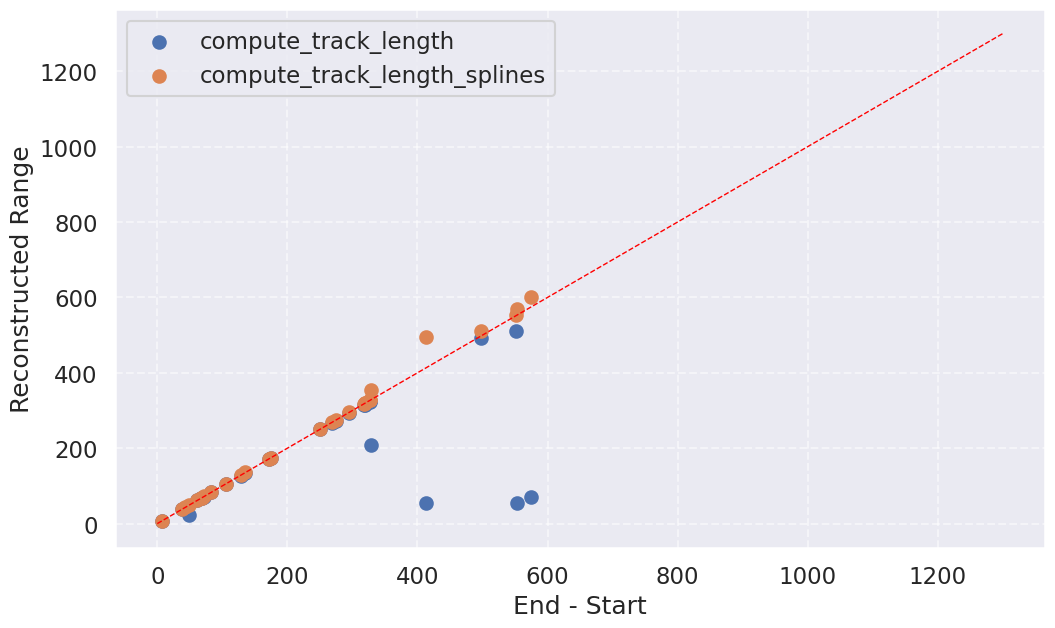

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(diffs, lengths, label='compute_track_length')
ax.scatter(diffs, lengths2, label='compute_track_length_splines')
ax.plot(np.linspace(0, 1300, 10), np.linspace(0, 1300, 10), linewidth=1, linestyle='--', color='red')
ax.grid(linestyle='--', alpha=0.5)
ax.set_xlabel('End - Start')
ax.set_ylabel('Reconstructed Range')
ax.legend()

The CSDARange vs. Energy table for [protons](https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html) and [muons](https://pdg.lbl.gov/2012/AtomicNuclearProperties/MUON_ELOSS_TABLES/muonloss_289.pdf) are stored as `.txt` files under `analysis/post_processing/reconstruction/tables`. To reconstruct the momentum or the kinetic energy using the track length, we are interested in the **CSDARange (g/cm^2)** values vs. **T (Kinetic Energy)**. Note that CSDARange must be divided by the liquid argon density $\rho = 1.396$ g/cm^3 to get the actual integrated length values in cm. 

In [14]:
proton_tab = pd.read_csv(os.path.join(LARTPC_MLRECO_PATH, 
    'analysis/post_processing/reconstruction/tables/pE_liquid_argon.txt'), delimiter=' ', index_col=False)
muon_tab   = pd.read_csv(os.path.join(LARTPC_MLRECO_PATH, 
    'analysis/post_processing/reconstruction/tables/muE_liquid_argon.txt'), delimiter=' ', index_col=False)
# These are global constants such as argon density, electron mass, etc. 
from mlreco.utils.globals import *

Let us construct an interpolating function over the range of available table data points. Again, as a sanity check, we will plot the fitted spline alongside the actual datapoints from the tables. 

In [15]:
from scipy.interpolate import UnivariateSpline, CubicSpline
from functools import partial

In [16]:
# Using Piecewise Linear
# f_muon = partial(np.interp, xp=muon_tab['CSDARange'] / ARGON_DENSITY, fp=muon_tab['T'])
# f_proton = partial(np.interp, xp=proton_tab['CSDARange'] / ARGON_DENSITY, fp=proton_tab['T'])

# Using Splines
f_muon = CubicSpline(muon_tab['CSDARange'] / ARGON_DENSITY, muon_tab['T'])
f_proton = CubicSpline(proton_tab['CSDARange'] / ARGON_DENSITY, proton_tab['T'])

In [17]:
# Sanity check for visualizing quality of spline fit
x_muon = muon_tab['CSDARange'] / ARGON_DENSITY
y_muon = f_muon(x_muon)

x_proton = proton_tab['CSDARange'] / ARGON_DENSITY
y_proton = f_proton(x_proton)

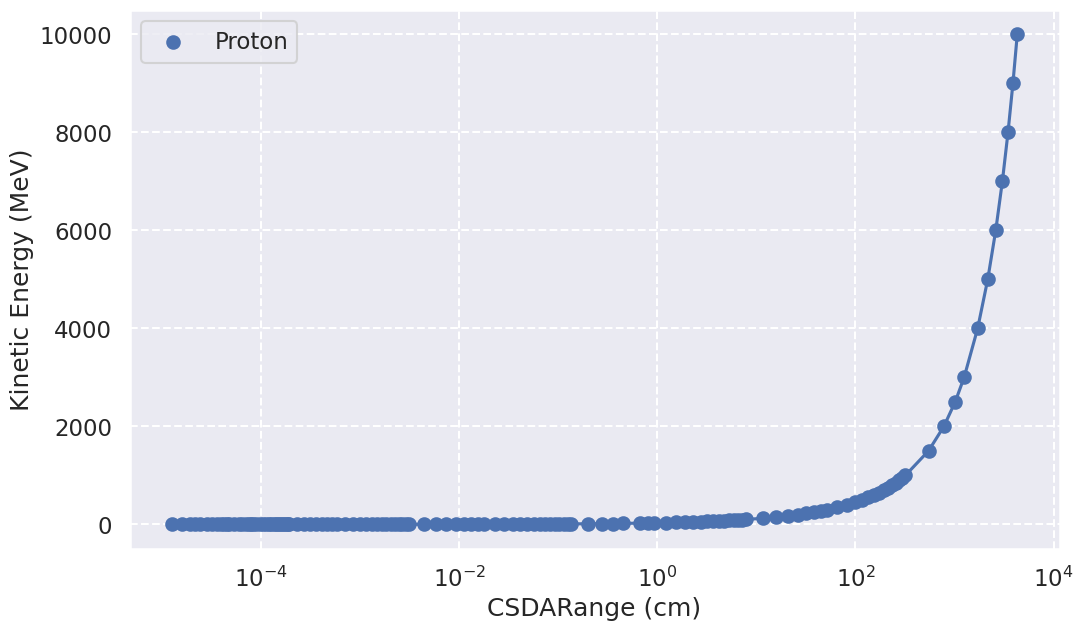

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(proton_tab['CSDARange'] / ARGON_DENSITY, proton_tab['T'], label='Proton')
ax.plot(x_proton, y_proton)
ax.grid(linestyle='--')
ax.set_xlabel('CSDARange (cm)')
ax.set_ylabel('Kinetic Energy (MeV)')
ax.set_xscale('log')
# ax.set_ylim(0, 2000)
ax.legend()

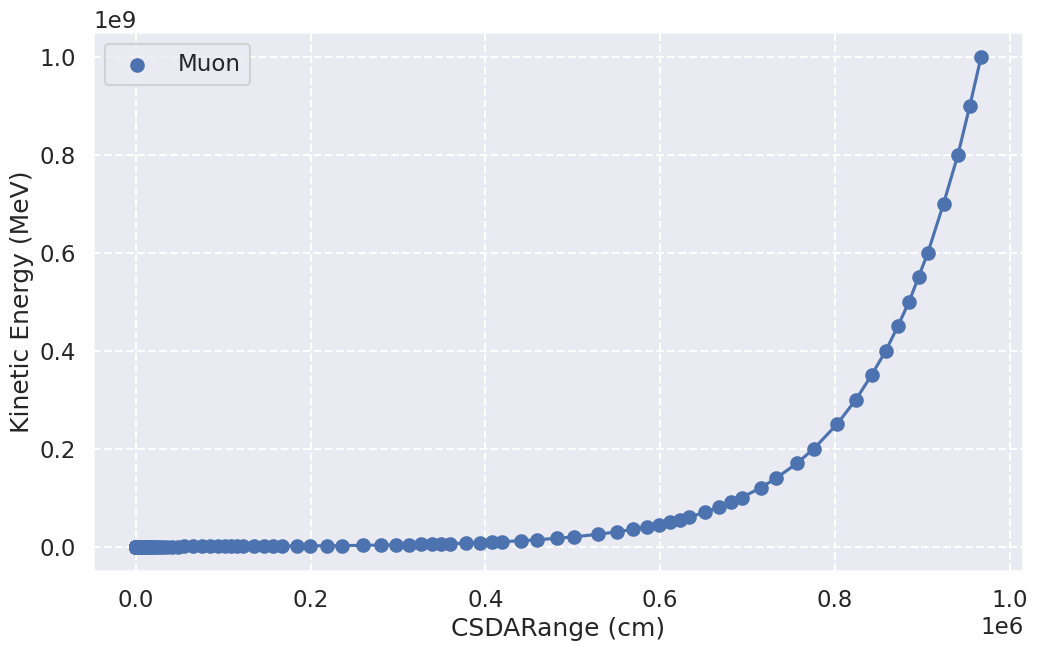

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(muon_tab['CSDARange'] / ARGON_DENSITY, muon_tab['T'], label='Muon')
ax.plot(x_muon, y_muon)
ax.grid(linestyle='--')
ax.set_xlabel('CSDARange (cm)')
ax.set_ylabel('Kinetic Energy (MeV)')
ax.legend()

If the spline interpolation seems reasonable, we can compute the range-based kinetic energy of muons and protons. We will gather 20 events for plotting:

In [20]:
muon_true_E, muon_reco_E = [], []
proton_true_E, proton_reco_E = [], []
for i in tqdm(range(20)):
    data, result = manager.forward(iteration=i)
    manager.load_representations(data, result, mode='all')
    manager.run_post_processing(data, result)
    
    particles          = result['particles'][0]
    truth_particles    = result['truth_particles'][0]
    interactions       = result['interactions'][0]
    truth_interactions = result['truth_interactions'][0]
    
    true_tracks = [p for p in truth_particles if p.semantic_type == 1]
    
    for p in true_tracks:
        if p.nu_id != 1:
            continue
        length = compute_track_length(p.truth_points) # Remember to convert to cm!
        # Muons must be a contained primary
        if p.pid == 2 and p.is_contained and int(p.is_primary) == 1:
            muon_true_E.append(p.energy_init - MUON_MASS) # Since we're comparing KE
            muon_reco_E.append(float(f_muon(length)))
        # Protons must be a contained primary without secondaries
        if p.pid == 4 and p.is_contained and int(p.is_primary) == 1 \
                      and p._children_counts[0] == 0 and p._children_counts[1] == 0:
            # p._children_counts is a np.array storing the number of childrens for each semantic class
            # i.e., p._children_counts[0] counts the number of children em showers. 
            proton_true_E.append(p.energy_init - PROTON_MASS)
            proton_reco_E.append(float(f_proton(length)))

  0%|          | 0/20 [00:00<?, ?it/s]

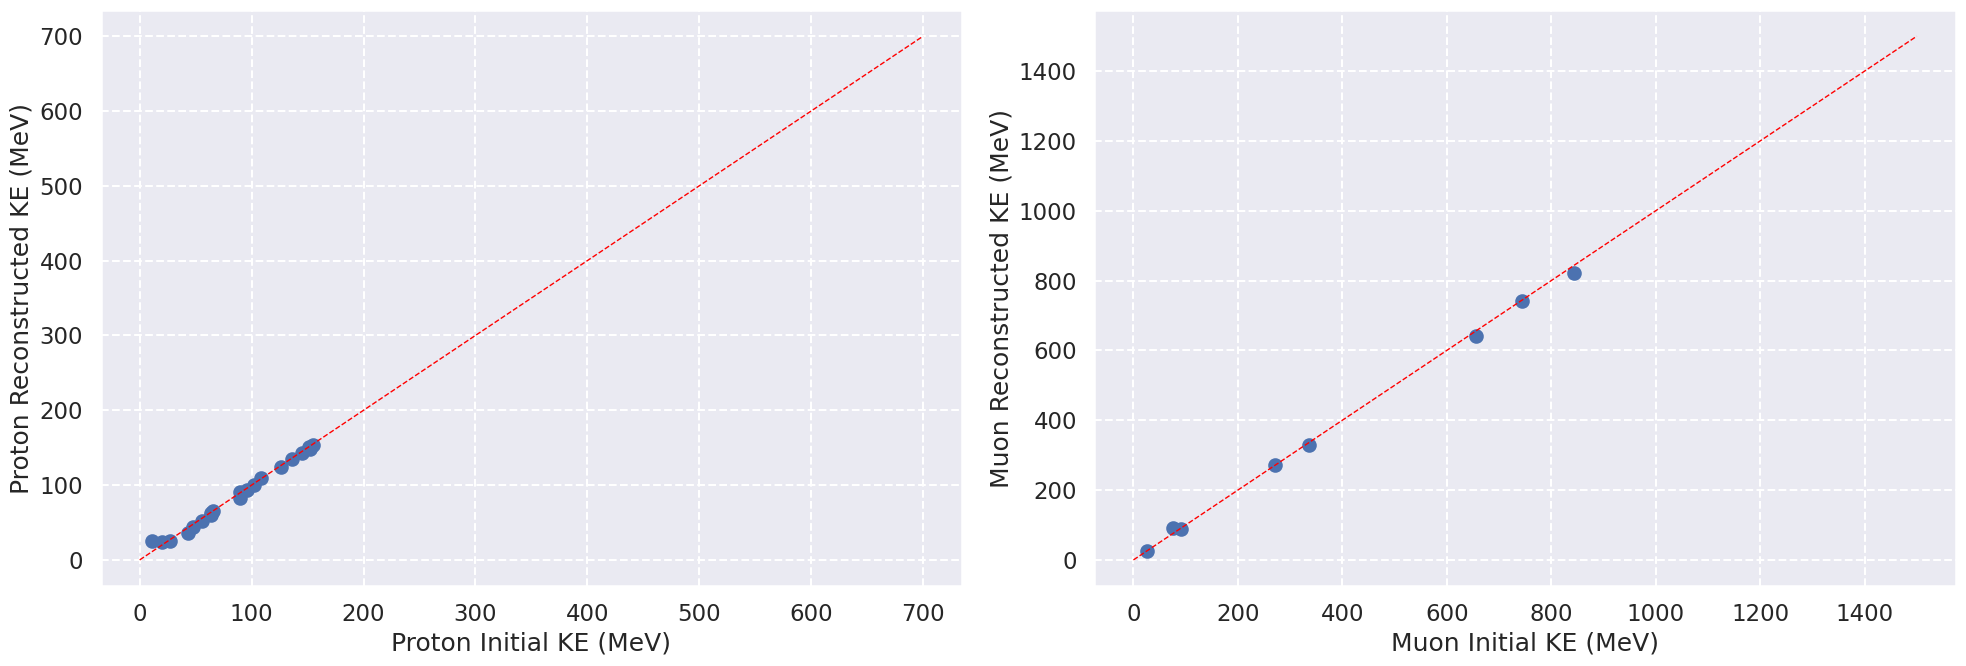

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].grid(linestyle='--', )
ax[0].plot(np.linspace(0, 700, 10), np.linspace(0, 700, 10), linewidth=1, linestyle='--', color='red')
ax[0].scatter(proton_true_E, proton_reco_E)
ax[0].set_xlabel('Proton Initial KE (MeV)')
ax[0].set_ylabel('Proton Reconstructed KE (MeV)')

ax[1].grid(linestyle='--', )
ax[1].plot(np.linspace(0, 1500, 10), np.linspace(0, 1500, 10), linewidth=1, linestyle='--', color='red')
ax[1].scatter(muon_true_E, muon_reco_E)
ax[1].set_xlabel('Muon Initial KE (MeV)')
ax[1].set_ylabel('Muon Reconstructed KE (MeV)')
fig.tight_layout()

For contained muons and protons, we can see that (for most cases) range-based $KE$ reconstruction works reasonably well. The off-diagonals for protons are likely due to secondary interactions for protons. At this stage it is better to submit a batch job for higher statistics. 

```bash
python3 $PATH_TO_LARML3D/analysis/run.py ./track_momentum_high_stat.cfg 
```

In [22]:
df_parts = pd.read_csv('/sdf/data/neutrino/icarus/workshop2023/csvs/track_calorimetry/particles.csv')
df_protons = df_parts.query('true_particle_nu_id == 1 and true_particle_type == 4')
df_muons = df_parts.query('true_particle_nu_id == 1 and true_particle_type == 2')

In [23]:
df_protons = df_protons.query('true_children_counts_0 == 0 and \
                               true_children_counts_1 == 0 and \
                               true_energy_init > 40 and \
                               true_particle_is_primary == 1 and \
                               true_particle_is_contained and \
                               reco_particle_type == 4')

df_muons = df_muons.query('true_particle_is_primary == 1 and \
                           true_particle_is_contained and \
                           reco_particle_type == 2')

In [24]:
df_protons

,Index,particle_match_counts,true_particle_id,true_particle_interaction_id,true_particle_type,true_particle_is_contained,true_particle_nu_id,true_particle_is_primary,true_particle_size,true_particle_semantic_type,...,reco_particle_start_dir_x,reco_particle_start_dir_y,reco_particle_start_dir_z,reco_particle_end_dir_x,reco_particle_end_dir_y,reco_particle_end_dir_z,reco_particle_length,reco_csda_kinetic_energy,reco_particle_depositions_sum,reco_matched
1,0,0.913979,1,0,4,True,1,True,85,1,...,0.164264,0.559016,0.812723,0.164264,0.559016,0.812723,8.005036,101.330246,19319.958984,1
259,2,0.983607,1,0,4,True,1,True,180,1,...,0.652729,-0.669461,0.354635,0.652729,-0.669461,0.354635,15.346921,147.136353,24265.757812,1
260,2,0.058824,6,0,4,True,1,True,6,1,...,0.707066,-0.000015,0.707148,0.707066,-0.000015,0.707148,0.600000,23.433889,3430.314453,1
261,2,0.916667,7,0,4,True,1,True,11,1,...,0.707066,-0.000015,0.707148,0.707066,-0.000015,0.707148,0.600000,23.433889,3430.314453,1
400,3,0.992754,0,0,4,True,1,True,138,1,...,-0.174522,0.345652,0.921990,-0.174522,0.345652,0.921990,11.159600,122.496867,21044.337891,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243567,669,0.977465,1,0,4,True,1,True,355,1,...,0.361633,0.533870,0.764332,0.361633,0.533870,0.764332,30.203289,218.615196,50852.742188,1
243700,670,1.000000,0,0,4,True,1,True,11,1,...,-0.861880,0.496234,0.104477,-0.861880,0.496234,0.104477,2.011599,46.385932,6494.986816,1
243862,671,0.868687,0,0,4,True,1,True,99,1,...,0.095997,-0.489668,0.866608,0.095997,-0.489668,0.866608,7.532954,97.865234,15371.152344,1
243863,671,0.905660,1,0,4,True,1,True,48,1,...,0.550298,0.832727,0.061137,0.550298,0.832727,0.061137,4.090092,69.220896,11130.690430,1


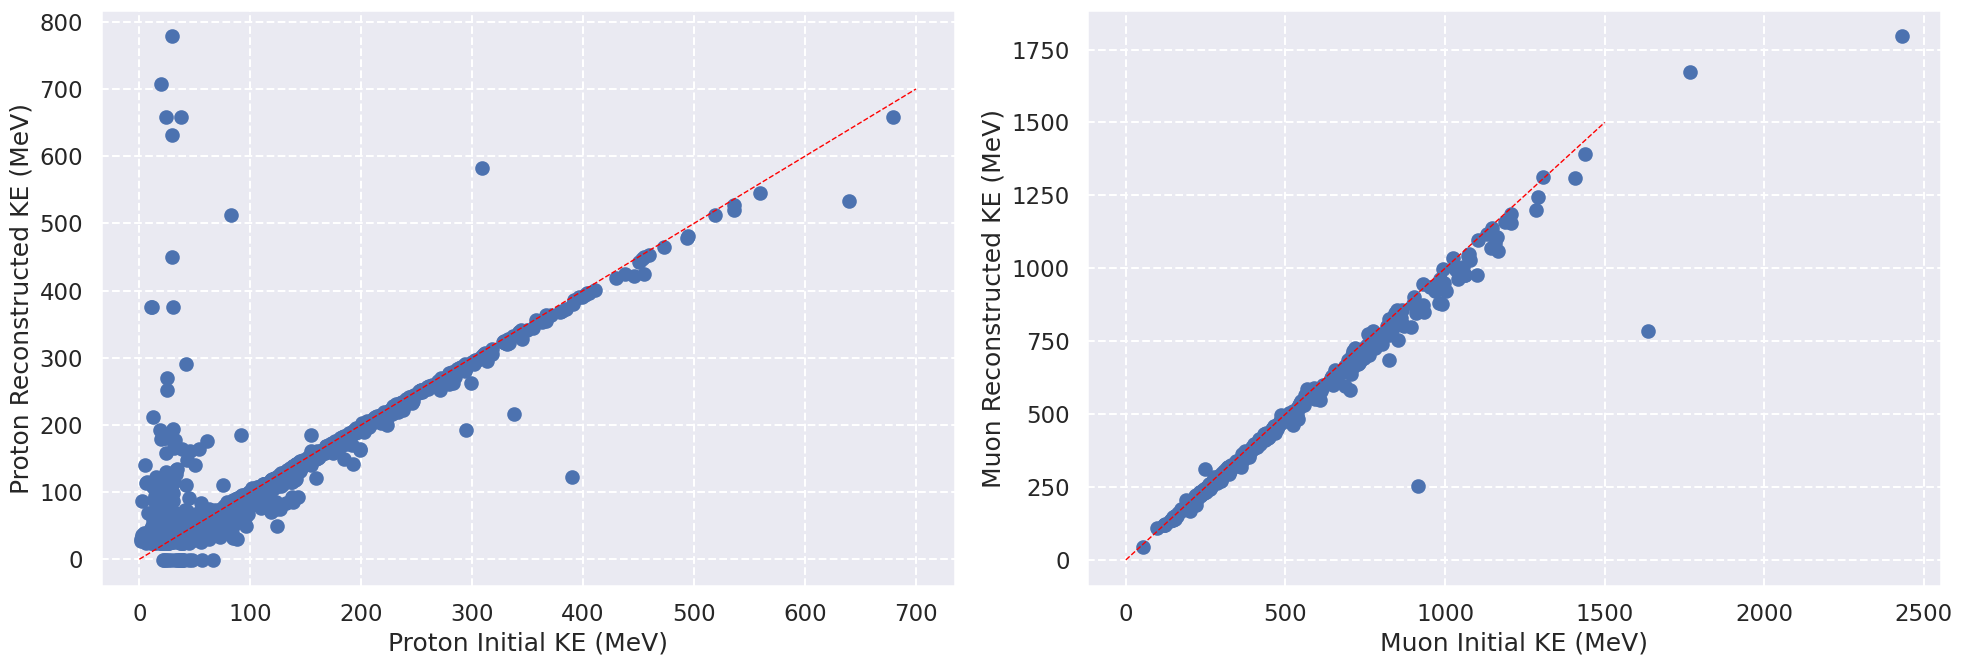

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].grid(linestyle='--', )
ax[0].plot(np.linspace(0, 700, 10), np.linspace(0, 700, 10), linewidth=1, linestyle='--', color='red')
ax[0].scatter(df_protons['true_energy_init'] - PROTON_MASS, df_protons['reco_csda_kinetic_energy'])
ax[0].set_xlabel('Proton Initial KE (MeV)')
ax[0].set_ylabel('Proton Reconstructed KE (MeV)')

ax[1].grid(linestyle='--', )
ax[1].plot(np.linspace(0, 1500, 10), np.linspace(0, 1500, 10), linewidth=1, linestyle='--', color='red')
ax[1].scatter(df_muons['true_energy_init'] - MUON_MASS, df_muons['reco_csda_kinetic_energy'])
ax[1].set_xlabel('Muon Initial KE (MeV)')
ax[1].set_ylabel('Muon Reconstructed KE (MeV)')
fig.tight_layout()